In [1]:

import numpy as np
import matplotlib.pyplot as plt
import math
import ipympl
from timeit import default_timer as timer

In [2]:
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import openbabel as ob
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
import nglview as nv

In [3]:
from load_data import load_file
from helper_functions import calc_scaling,symmetrize,rotate_to_reference,single_rotD,single_rotP
from calc_average import full_average,full_average_IR,full_average_R,full_average_R_orth,numerical_sector_average
from calc_single import oriented_IR,oriented_R,single_rot_IR,single_rot_R

In [4]:
from plotting_functions import create_average_spec_single

In [5]:
def convert_to_mol(filename,molfilename):
    #print("conv")
    obConversion = ob.OBConversion()
    obConversion.SetInAndOutFormats("xyz", "mol") 
    mol = ob.OBMol()
    obConversion.ReadFile(mol, filename)
#    mol.AddHydrogens()
    outMDL = obConversion.WriteString(mol)
   # spl=outMDL.split("\t")
   # smiles = spl[0]
 #   print(smiles, spl[1])
    
    obConversion.WriteFile(mol,molfilename)

def get_atoms(mol,filename,savexyz=False,calcvol=False):  
    mol.AddHydrogens()
  # print(mol.NumAtoms())
    S_coords=np.zeros(3)
    neighb2_idxs=np.zeros(4,dtype=int)
    neighb2_num=np.zeros(4,dtype=int)
    thiol=False
    n1_indx=-1
    for a in ob.OBMolAtomIter(mol): 
        if a.GetAtomicNum()==16: 
            thiol=False
            n=0
            print("found 16")
            numneig=0
            for neighbour in ob.OBAtomAtomIter(a):
                if neighbour.GetAtomicNum()==79: 
                      thiol=True
                numneig+=1    
            if numneig==1:
                thiol=True
            if thiol==True:
                S_indx=a.GetIdx()
                S_coords[0]=a.GetX()
                S_coords[1]=a.GetY()
                S_coords[2]=a.GetZ()
                for neighbour in ob.OBAtomAtomIter(a):
                    
                    if neighbour.GetAtomicNum()==79:
                        Au_indx=neighbour.GetIdx()
                    else:
                        n1_indx=neighbour.GetIdx()
                        for neighbour2 in ob.OBAtomAtomIter(neighbour):
                            if neighbour2.GetIdx()==S_indx:
                                n+=1
                                continue
                            neighb2_idxs[n]=neighbour2.GetIdx()                     
                            neighb2_num[n]=neighbour2.GetAtomicNum()
                            n+=1
                        break
            
    if n1_indx==-1:
        return 0
    n2_indx=neighb2_idxs[np.argmax(neighb2_num)]
    print(S_indx,n1_indx,n2_indx)
    coords_orig = [[atom.GetX(),atom.GetY(),atom.GetZ()] for atom in ob.OBMolAtomIter(mol)] 
    ## translate S to origin
    translate=np.array([-S_coords[0],-S_coords[1],-S_coords[2]] )
#    print("translate ",translate)
    trl=ob.vector3(-S_coords[0],-S_coords[1],-S_coords[2])
    mol.Translate(trl)
    atnums= [atom.GetAtomicNum() for atom in ob.OBMolAtomIter(mol)]
    coords = [[atom.GetX(),atom.GetY(),atom.GetZ()] for atom in ob.OBMolAtomIter(mol)] 
    
    ## rotate n1 to z axis around y axis
    ## phi = angle between z axis and S-n1 bond in x-z plane
    n1_coords=coords[n1_indx-1]
    n1_norm=np.linalg.norm(n1_coords)
##    print("n1 ",n1_coords,n1_norm)
    n1_normed=n1_coords/n1_norm
##    print(n1_normed,np.linalg.norm(n1_normed))
    cosphi=n1_normed[2]/np.sqrt(1-np.power(n1_normed[1],2))
    sinphi=n1_normed[0]/np.sqrt(1-np.power(n1_normed[1],2))
##    print("phi: ",sinphi,cosphi,np.power(sinphi,2)+np.power(cosphi,2))

    rot_matrix=np.zeros((3,3))
    rot_matrix[0,0]=cosphi
    rot_matrix[0,2]=-sinphi
    rot_matrix[2,0]=sinphi
    rot_matrix[1,1]=1
    rot_matrix[2,2]=cosphi

    rotcoords=np.transpose(np.matmul(rot_matrix,np.transpose(coords)))
 ##   print(rotcoords)
 ##   print(atnums)
    
    n1_coords2=rotcoords[n1_indx-1]
    n1_norm2=np.linalg.norm(n1_coords2)
   ## print("n1 ",n1_coords2,n1_norm2)
    n1_normed2=n1_coords2/n1_norm2
 #   print(n1_normed2,np.linalg.norm(n1_normed2))
    cosrho=n1_normed2[2]/np.sqrt(1-np.power(n1_normed2[0],2))
    sinrho=n1_normed2[1]/np.sqrt(1-np.power(n1_normed2[0],2))
 #   print("rho: ",sinrho,cosrho,np.power(sinrho,2)+np.power(cosrho,2))

    rot_matrix2=np.zeros((3,3))
    rot_matrix2[0,0]=1
    rot_matrix2[1,1]=cosrho
    rot_matrix2[1,2]=-sinrho
    rot_matrix2[2,1]=sinrho
    rot_matrix2[2,2]=cosrho
    
    rotcoords2=np.transpose(np.matmul(rot_matrix2,np.transpose(rotcoords)))
 #   print(rotcoords2)
    
    n2_coords3=rotcoords2[n2_indx-1]
    n2_norm3=np.linalg.norm(n2_coords3)
 #   print(n2_coords3,n2_norm3)
    n2_normed3=n2_coords3/n2_norm3
 #   print(n2_normed3)
    costheta=n2_normed3[0]/np.sqrt(1-np.power(n2_normed3[2],2))
    sintheta=n2_normed3[1]/np.sqrt(1-np.power(n2_normed3[2],2))
 #   print(sintheta,costheta,np.power(sintheta,2)+np.power(costheta,2))

    rot_matrix3=np.zeros((3,3))
    rot_matrix3[0,0]=costheta
    rot_matrix3[0,1]=sintheta
    rot_matrix3[1,0]=-sintheta
    rot_matrix3[1,1]=costheta
    rot_matrix3[2,2]=1

#    rotcoords3=np.transpose(np.matmul(rot_matrix3,np.transpose(rotcoords2)))
#   print(rotcoords3)     
 
#    molfilename="rot2_{}.xyz".format(filename[:-4])
#    xyz="{} \n\n".format(len(atnums))
#    molfile = open(molfilename, "w+")   
#    molfile.write(xyz)
#    for m in range(0,len(atnums)):
#        molfile.write("{} {} {} {} \n".format(atnums[m],rotcoords2[m,0],rotcoords2[m,1],rotcoords2[m,2]))
#    molfile.close()
#    print(molfilename)
 
 
 #   molfilename="rot3_{}.xyz".format(filename[:-4])
 #   xyz="{} \n\n".format(len(atnums))
 #   molfile = open(molfilename, "w+")   
 #   molfile.write(xyz)
 #   for m in range(0,len(atnums)):
 #       molfile.write("{} {} {} {} \n".format(atnums[m],rotcoords3[m,0],rotcoords3[m,1],rotcoords3[m,2]))
 #   molfile.close()
 #   print(molfilename)
    
#    print("orig ", coords_orig)
    coord_test=np.zeros(np.shape(coords_orig))
    for i in range(0,len(coords_orig)):
        coord_test[i]=coords_orig[i]+translate
    rot=np.matmul(rot_matrix3,np.matmul(rot_matrix2,rot_matrix))
#    print(rot)
    if savexyz:
        rotcoords4=np.transpose(np.matmul(rot,np.transpose(coord_test)))
 #test   
  ##  for i in range(0,len(rotcoords4)):
  ##      rotcoords4[i]=rotcoords4[i]+translate
#    print(rotcoords4)
        molfilename="rot_{}.xyz".format(filename[:-4])
        xyz="{} \n\n".format(len(atnums))
        molfile = open(molfilename, "w+")   
        molfile.write(xyz)
        for m in range(0,len(atnums)):
            molfile.write("  {}    {:.8f} {:.8f} {:.8f} \n".format(atnums[m],rotcoords4[m,0],rotcoords4[m,1],rotcoords4[m,2]))
        molfile.close()
        print(molfilename)
        convert_to_mol(molfilename,molfilename[:-3]+"mol")
#     if calcvol:     
#         # get Van der Waals radii
#         vdw=np.zeros_like(atnums,dtype=float)
#         etab=ob.OBElementTable()
#         for i,a in enumerate(ob.OBMolAtomIter(mol)): 
#             an=a.GetAtomicNum()
#            # print(an)
#             vdw[i]= etab.GetVdwRad(an)

        
#       # consider only heavy atoms
#         heavyc=np.zeros_like(coords)
#         heavyrot=np.zeros_like(coords)
#         hvdw=np.zeros_like(vdw)
#         for s,c in enumerate(coords):
#          #   if atnums[s]==1:
#          #       continue
#             if atnums[s]==79:
#                 hvdw[s]=0 #-vdw[s] # to have gap size from gold surface??
#         #        heavyc[s]=coords[S_indx]
#                 heavyrot[s]=np.array([0,0,0])
#                 continue 
#       #          continue
#        #     heavyc[s]=c
#             heavyrot[s]=rotcoords4[s]
#             hvdw[s]=vdw[s]
#    #     print("VdW ",hvdw)
#    #     print("modified coords ")
#       #  print(heavyc)
#    #     print(heavyrot)
#         torad=2*np.pi/360
#         b=22*torad # tilt angle from exps
#         nrots=24
#         tcell=np.zeros((nrots,3))
#         for i in range(nrots):
#             a=(180/nrots*i)*torad
#             tilted=single_rot(heavyrot,a=a,b=b,c=0)
#             tcell[i]=get_oriented_box(tilted,hvdw,0) #heavyrot #(rotcoords4,vdw)
#         zzs=[]
#         zzs_std=[]
#         nt=36
#         for t in range(nt):   
#             zzm=0
#             zzs_all=[]
#             for i in range(nrots):
#                 a=(180/nrots*i)*torad
#                 b=(90/nt*t)*torad
#                 tilted=single_rot(heavyrot,a=a,b=b,c=0)
#                 xx,yy,zz=get_oriented_box(tilted,hvdw,0)
#                 zzm+=zz
#                 zzs_all.append(zz)
#             zzs.append(zzm/nrots)
#             zzs_std.append(np.std(zzs_all))
                
#         ocell=get_oriented_box(heavyrot,hvdw)
#         mcell=get_maxdist_box(heavyrot,hvdw) #(coords,vdw)
#         icell=get_inertia_box(heavyrot,hvdw,molfilename2=dirname+"\\\\"+molfilename[:-3]+"mol") #(coords,vdw)
        
#      #   except:
#       #      print("error")

        
#     rotfilename="rot_matrix_{}.dat".format(filename[:-4])
#     rotfile = open(rotfilename, "w+")   
#     rotfile.write("translation\n")
#     rotfile.write("{:.8f} {:.8f} {:.8f} \n".format(translate[0],translate[1],translate[2]))
#     rotfile.write("rotation\n")
#     for dim in range(3):
#         rotfile.write("{:.8f} {:.8f} {:.8f} \n".format(rot[dim,0],rot[dim,1],rot[dim,2]))
#     rotfile.close()
#     print(rotfilename)
#     if calcvol:
#         return ar,ocell,mcell,icell,tcell,zzs,zzs_std
#     return 0
    return molfilename[:-3]+"mol"

Loaded  freq-19813-90-2.fchk
SMILES:  [Au]Sc1[cH][cH]c([cH][cH]1)c1[cH][cH][cH][cH][cH]1


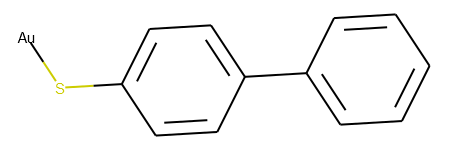

In [6]:
outfilename="freq-19813-90-2.out"   # less accurate
filename="freq-19813-90-2.fchk"   # more accurate
fr,Z,Q,D,P0,nat,aniso=load_file(filename)

obConversion = ob.OBConversion()
obConversion.SetInAndOutFormats("out", "can") 
obConversion.SetOptions(str("h"), ob.OBConversion.OUTOPTIONS)
mol0 = ob.OBMol()
obConversion.ReadFile(mol0, outfilename)
#    mol.AddHydrogens()

outMDL = obConversion.WriteString(mol0)
spl=outMDL.split("\t")
smiles = spl[0]
if len(smiles)<2:
        print("error in smiles generation")
        smiles=filename
print("SMILES: ",smiles)

    
# #smiles=convert_to_smiles(outfilename)
mol=Chem.MolFromSmiles(smiles)
display(mol)

obConversion.SetOutFormat("mol") 
sdfmol = obConversion.WriteString(mol0)


In [7]:

def rotate_view(view, phi=0, theta=0, xi=0, degrees=True):
    radians = 1
    if degrees: radians = math.pi / 180
    view.control.spin([0, 0, 1], phi*radians)
    view.control.spin([1, 0, 0], theta*radians)
    view.control.spin([0, 0, 1], xi*radians)
    


In [8]:
sdfmolfile=outfilename[:-3]+"sdf"
obConversion.WriteFile(mol0,sdfmolfile)  
view0=nv.show_structure_file(sdfmolfile)
#view0.add_axes()
rotate_view(view0, phi=0, theta=0, xi=0, degrees=True)
#view0.shape.add_sphere([0.0, 0.0, 0.0], [0,0,1], 1.0)
view0


NGLWidget()

In [9]:
rotfile=get_atoms(mol0,outfilename,savexyz=1,calcvol=False)
view=nv.show_structure_file(rotfile)
rotate_view(view, phi=0, theta=0, xi=0, degrees=True)
#view.add_axes()
#view.add_representation(repr_type='axes',  showBox=1, showAxes=1)
view

found 16
13 10 11
rot_freq-19813-90-2.xyz


NGLWidget()

In [10]:
phys_params=dict(laser =785, #633, 
                 T = 298.15
                 )

# calculate intensity scaling factors
v0= math.pow(10, 7)/phys_params['laser']

scalingIR,scaling,scalingexp= calc_scaling(phys_params['T'])
pi=math.pi
torad=2*pi/360

In [11]:
def normalize_stick(freqs,ints,wn,br_ints,res):
    normm=np.argmax(ints)
    maxdf=0
    maxint=np.max(ints)
    # look for peak with largest separation from neighboring peaks
    # peak intensity has to be larger than maxintensity /20
    # neighbours: int larger than int of chosen peak /10
    # weighting distance with intensity ratio
    # if no such peak, use max intenisty peak
    for n in range(1,len(freqs)-1):
        if ints[n]<maxint/20:
            continue
  #      print("fr int ",freqs[n],ints[n])
        df1=0
        for m in range(n+1,len(freqs)):
            if ints[m]>ints[n]/10:
                df1=ints[n]/ints[m]*(freqs[m]-freqs[n])
                break
        df2=0
        for l in range(0,n):
            if ints[l]>ints[n]/10:       
                df2=ints[n]/ints[l]*(freqs[n]-freqs[l])
                break
      #  print("df ",df1,df2)
        df=min(df1,df2)
        if df>maxdf:
            maxdf=df
            normm=n
 #   print(maxdf,freqs[normm])
    br_int=br_ints[0]
    for n,w in enumerate(wn):
        if abs(w-freqs[normm])<res:
            br_int=br_ints[n]
            break
    n_ints=br_int*ints/ints[normm]
    return n_ints

def plot_spectrum_oriented(phi,theta,show_av,broadening,gammaIR,gammaR):
    # modes: list of normal modes to calculate
    modes=range(0,len(fr)) 

    rotate=0    # rotate molecule to reference orientation before analysis, NOT IMPLEMENTED YET
    numerical=0 # perform numerical tests
    single=1    # get intensities for single rotations
    
    th=theta*torad  
    ph=phi*torad 

    Lm=1

    # Full orientation averages
    nummodes=len(modes)
    conv_av=np.zeros((nummodes))     # conversion intensity
    ir_av=np.zeros((nummodes))    # IR intensity
    r_av=np.zeros((nummodes))     # Raman Stokes intensity, parallel fields
    r_a_av=np.zeros((nummodes))   # Raman anti-Stokes intensity, parallel fields
    r_av_ort=np.zeros((nummodes)) # Raman Stokes intensity, orthogonal fields

    # Single orientations
    ir_single=np.zeros((nummodes))  # IR intensity
    r_single=np.zeros((nummodes))   # Raman Stokes, parallel fields
    conv_single=np.zeros((nummodes)) # Conversion intensity, parallel fields

    for n,m in enumerate(modes):
        P=symmetrize(P0[m,:,:])
        if rotate:
            Drot,Prot,R=rotate_to_reference(D[m,:],P,Z,Q)

    # Calculate frequency-dependent scaling factors
        # Usual Stokes for thermal population
        scalingR=Lm*scaling* math.pow(v0 - fr[m], 4) / (
                    fr[m] * (1 - math.exp(scalingexp * fr[m]))) 
        # Usual anti-Stokes for thermal population
        scalingaR=Lm*scaling* math.pow(v0 + fr[m], 4) / fr[m] *(
               1/(-1+math.exp(-scalingexp * fr[m]))) # 
        # For THOR: anti-Stokes without population
        scalingTHOR=Lm*scaling* math.pow(v0 + fr[m], 4) / fr[m] 

    # Calculate full averages analytically
        starta=timer()
        conv_av[n] = scalingIR *scalingTHOR*full_average(D[m,:],P)  
        ir_av[n]=scalingIR*full_average_IR(D[m,:]) 
        Rav=full_average_R(P)
        r_av[n]=scalingR*Rav 
        enda=timer()
        r_a_av[n]=scalingaR*Rav 
        r_ort,depol=full_average_R_orth(P)
        r_av_ort[n]=scalingR*r_ort 

    # Test: Calculate full averages numerically 
        if numerical:
                startm=timer()
                ir_numav, r_numav,p_numav=numerical_sector_average(D[m,:],P,1,1,0,0,0)
                ir_numav=scalingIR*ir_numav
                r_numav=scalingR*r_numav
                p_numav=scalingIR *scalingTHOR*p_numav
                endm=timer()
                print("Time for evaluation\n   Analytic \t{:.1e}s \n   Numerical \t{:.1e}s \n   Num/An \t{:.1e}".format(
                    enda-starta,endm-startm,(endm-startm)/(enda-starta)))
                print("Abs. and rel. error of numerical results\n   IR \t\t{:.2e}\t{:.2f}% \n   Raman \t{:.2e}\t{:.2f}% \n   Conv \t{:.2e}\t{:.2f}%".format(
                    ir_numav-ir_av[n],(ir_numav-ir_av[n])/ir_av[n]*100,r_numav-r_av[n],(r_numav-r_av[n])/r_av[n]*100,
                    p_numav-conv_av[n],(p_numav-conv_av[n])/conv_av[n]*100))
                print("-----------------------------------------------")

    # Calculate single orientations analytically
        if single:
                if numerical:
                    print("IR intensity                            | Raman intensity")
                    print("single    numeric1  numeric2   orient   | single    numeric1   numeric2   orient")
                ir=single_rot_IR(D[m,:],a=ph,b=th,c=0) 
                r=single_rot_R(P,a=ph,b=th,c=0)
                ir_single[n]=scalingIR*ir
                r_single[n]=scalingR*r
                conv_single[n]=scalingIR*scalingTHOR*ir*r

    # Tests: numerical average on rotated D and P should give the same value 
    #             when using nump=1, 
    #             or in the limit of k->inf and l->inf
    #        rotating D and P first and using field oriented along z should also give the same
                if numerical:
                            Drot=single_rotD(D[m,:],a=ph,b=th,c=0)
                            Prot=single_rotP(P,a=ph,b=th,c=0)
                            ir_snumav, r_snumav,p_snumav=numerical_sector_average(Drot,Prot,1,1,0,0,0,nump=1)
                            ir_snumav2, r_snumav2,p_snumav2=numerical_sector_average(Drot,Prot,1000000,1000000,0,0,0,nump=30)
                            print("{:.3e} {:.3e} {:.3e} {:.3e} | {:.3e} {:.3e} {:.3e} {:.3e}".format(ir_single[n],
                                scalingIR*ir_snumav,scalingIR*ir_snumav2,scalingIR*oriented_IR(Drot),
                                r_single[n],
                                scalingR*r_snumav,scalingR*r_snumav2,scalingR*oriented_R(Prot)))

    
    xmin=30
    xmax=1000
    res=0.2
    sclf=0.98                        

    title=r'$\phi$={:.1f}$\degree$ $\theta$={:.1f}$\degree$'.format(ph/torad,th/torad)
    wn,R_spec,IR_spec,conv_spec,freqs,prod_ints,R_ints,IR_ints=create_average_spec_single(fr,  ir_single, r_single, 
                                                                                      conv_single,
                                                                                      xmin,xmax,res,gammaIR,gammaR,sclf)

    wn,R_spec_av,IR_spec_av,conv_spec_av,freqs,prod_ints_av,R_ints_av,IR_ints_av=create_average_spec_single(fr,  ir_av, r_av, conv_av,
                                                                                  xmin,xmax,res,gammaIR,gammaR,sclf)
    
    
    plt.rcParams.update({'font.size': 16})
    fig=plt.figure()
    fig.set_size_inches(6, 6)
    ax2=fig.add_subplot(311)
    ax3=fig.add_subplot(312,sharex=ax2)
    ax1=fig.add_subplot(313,sharex=ax2)    
    pmin=0 #int(xmin/res)
    pmax=int((xmax-xmin)/res)
    
    maxpr0=np.max(prod_ints)
    maxI0=np.max(IR_ints)
    maxR0=np.max(R_ints)
    if broadening=='broadened':
        ax3.fill_between(wn,R_spec,alpha=0.6,color='b',label='Raman')
        ax2.fill_between(wn,IR_spec,alpha=0.6,color='r',label='IR') 
        ax1.fill_between(wn,conv_spec,alpha=0.6,color='purple',label='conv') 
        maxpr0=np.max(conv_spec[pmin:pmax]) 
        maxI0=np.max(IR_spec[pmin:pmax])
        maxR0=np.max(R_spec[pmin:pmax])

    elif broadening=='both':
        ax3.fill_between(wn,R_spec,alpha=0.6,color='b',label='Raman')
        ax2.fill_between(wn,IR_spec,alpha=0.6,color='r',label='IR') 
        ax1.fill_between(wn,conv_spec,alpha=0.6,color='purple',label='conv') 
        n_IR_ints=normalize_stick(freqs,IR_ints,wn,IR_spec,res)
        n_R_ints=normalize_stick(freqs,R_ints,wn,R_spec,res)  
        n_prod_ints=normalize_stick(freqs,prod_ints,wn,conv_spec,res)
        markerline, stemline, baseline, =ax2.stem(freqs,n_IR_ints,
                                                 'k',basefmt='k', markerfmt='ok',
                                                  use_line_collection=True,bottom=0,label='IR')
        plt.setp(stemline, linewidth = 1.25,alpha=0.6)
        plt.setp(markerline, markersize = 2,alpha=0.6)  
        markerline, stemline, baseline, =ax3.stem(freqs,n_R_ints,
                                                 'k',basefmt='k', markerfmt='ok',
                                                  use_line_collection=True,bottom=0,label='Raman')
        plt.setp(stemline, linewidth = 1.25,alpha=0.6)
        plt.setp(markerline, markersize = 2,alpha=0.6)  
        markerline, stemline, baseline, =ax1.stem(freqs,n_prod_ints,
                                                 'k',basefmt='k', markerfmt='ok',
                                                  use_line_collection=True,bottom=0,label='Conv.')
        plt.setp(stemline, linewidth = 1.25,alpha=0.6)
        plt.setp(markerline, markersize = 2,alpha=0.6)
        
        maxpr0=np.max(conv_spec[pmin:pmax]) 
        maxI0=np.max(IR_spec[pmin:pmax])
        maxR0=np.max(R_spec[pmin:pmax])
        
        
    elif broadening=='stick':
        markerline, stemline, baseline, =ax2.stem(freqs,IR_ints,
                                                 'k',basefmt='k', markerfmt='ok',
                                                  use_line_collection=True,bottom=0,label='IR')
        plt.setp(stemline, linewidth = 1.25,alpha=0.6)
        plt.setp(markerline, markersize = 2,alpha=0.6)  
        markerline, stemline, baseline, =ax3.stem(freqs,R_ints,
                                                 'k',basefmt='k', markerfmt='ok',
                                                  use_line_collection=True,bottom=0,label='Raman')
        plt.setp(stemline, linewidth = 1.25,alpha=0.6)
        plt.setp(markerline, markersize = 2,alpha=0.6)  
        markerline, stemline, baseline, =ax1.stem(freqs,prod_ints,
                                                 'k',basefmt='k', markerfmt='ok',
                                                  use_line_collection=True,bottom=0,label='Conv.')
        plt.setp(stemline, linewidth = 1.25,alpha=0.6)
        plt.setp(markerline, markersize = 2,alpha=0.6)
    maxpr=maxpr0
    maxI=maxI0
    maxR=maxR0
    if show_av:
        maxpr1=np.max(prod_ints_av) 
        maxI1=np.max(IR_ints_av) 
        maxR1=np.max(R_ints_av) 
        if broadening=='broadened':
            ax3.fill_between(wn,R_spec_av,alpha=0.6,color='grey',label='Raman av')
            ax2.fill_between(wn,IR_spec_av,alpha=0.6,color='grey',label='IR av')
            ax1.fill_between(wn,conv_spec_av,alpha=0.6,color='grey',label='conv av')
            maxpr1=np.max(conv_spec_av[pmin:pmax]) 
            maxI1=np.max(IR_spec_av[pmin:pmax])
            maxR1=np.max(R_spec_av[pmin:pmax])
           
        elif broadening=='both':
            ax3.fill_between(wn,R_spec_av,alpha=0.6,color='grey',label='Raman av')
            ax2.fill_between(wn,IR_spec_av,alpha=0.6,color='grey',label='IR av')
            ax1.fill_between(wn,conv_spec_av,alpha=0.6,color='grey',label='conv av')
            maxpr1=np.max(conv_spec_av[pmin:pmax]) 
            maxI1=np.max(IR_spec_av[pmin:pmax])
            maxR1=np.max(R_spec_av[pmin:pmax])
            n_IR_ints_av=normalize_stick(freqs,IR_ints_av,wn,IR_spec_av,res)
            n_R_ints_av=normalize_stick(freqs,R_ints_av,wn,R_spec_av,res)
            n_prod_ints_av=normalize_stick(freqs,prod_ints_av,wn,conv_spec_av,res)
            markerline, stemline, baseline, =ax2.stem(freqs,n_IR_ints_av,
                                                     'grey',basefmt='grey', markerfmt='ok',
                                                      use_line_collection=True,bottom=0,label='IR')
            plt.setp(stemline, linewidth = 1.25,alpha=0.6)
            plt.setp(markerline, markersize = 2,alpha=0.6)  
            markerline, stemline, baseline, =ax3.stem(freqs,n_R_ints_av,
                                                     'grey',basefmt='grey', markerfmt='ok',
                                                      use_line_collection=True,bottom=0,label='Raman')
            plt.setp(stemline, linewidth = 1.25,alpha=0.6)
            plt.setp(markerline, markersize = 2,alpha=0.6)  
            markerline, stemline, baseline, =ax1.stem(freqs,n_prod_ints_av,
                                                     'grey',basefmt='grey', markerfmt='ok',
                                                      use_line_collection=True,bottom=0,label='Conv.')
            plt.setp(stemline, linewidth = 1.25,alpha=0.6)
            plt.setp(markerline, markersize = 2,alpha=0.6)  
            
        elif broadening=='stick':
            markerline, stemline, baseline, =ax2.stem(freqs,IR_ints_av,
                                                     'grey',basefmt='grey', markerfmt='ok',
                                                      use_line_collection=True,bottom=0,label='IR')
            plt.setp(stemline, linewidth = 1.25,alpha=0.6)
            plt.setp(markerline, markersize = 2,alpha=0.6)  
            markerline, stemline, baseline, =ax3.stem(freqs,R_ints_av,
                                                     'grey',basefmt='grey', markerfmt='ok',
                                                      use_line_collection=True,bottom=0,label='Raman')
            plt.setp(stemline, linewidth = 1.25,alpha=0.6)
            plt.setp(markerline, markersize = 2,alpha=0.6)  
            markerline, stemline, baseline, =ax1.stem(freqs,prod_ints_av,
                                                     'grey',basefmt='grey', markerfmt='ok',
                                                      use_line_collection=True,bottom=0,label='Conv.')
            plt.setp(stemline, linewidth = 1.25,alpha=0.6)
            plt.setp(markerline, markersize = 2,alpha=0.6)  
    
        maxpr=max(maxpr0, maxpr1) 
        maxI=max(maxI0,maxI1)
        maxR=max(maxR0,maxR1) 
    plt.xlim(xmin,xmax)
    ax1.set_ylim(-maxpr/100,1.2*maxpr)
    ax2.set_ylim(-maxI/100,1.2*maxI)
    ax3.set_ylim(-maxR/100,1.2*maxR)
    plt.setp(ax2.get_xticklabels(), visible=False)
    plt.setp(ax3.get_xticklabels(), visible=False)
    ax1.ticklabel_format(axis="y", style="sci", scilimits=(0,0),useMathText=True)
    ax2.ticklabel_format(axis="y", style="sci", scilimits=(0,0),useMathText=True)
    ax3.ticklabel_format(axis="y", style="sci", scilimits=(0,0),useMathText=True)
    ax2.set_title(title)
    plt.xlabel('Wavenumber (cm$^{-1}$)')
    ax2.set_ylabel('IR',color='r')
    ax3.set_ylabel('Raman',color='b')
    ax1.set_ylabel('Conv.',color='purple')
    ax1.yaxis.set_label_coords(-0.07,0.5)
    ax2.yaxis.set_label_coords(-0.07,0.5)
    ax3.yaxis.set_label_coords(-0.07,0.5)
    fig.tight_layout(pad=1.8, w_pad=0.01, h_pad=0.01)
    plt.show()


In [12]:
%matplotlib widget



interactive_plot = interactive(plot_spectrum_oriented, {'manual': True}, theta=widgets.BoundedFloatText(value=0,min=0,max=90.0,step=0.1,description='Tilt (x):',disabled=False),
         phi=widgets.BoundedFloatText(value=0,min=0,max=360.0,step=0.1,description='Rotation (z):',disabled=False),
         show_av=False,
         broadening=[('broadened'), ('stick'),('both')],
         gammaIR=widgets.FloatSlider(value=10, description='FWHM IR', max=50, min=0.1),
         gammaR=widgets.FloatSlider(value=10, description='FWHM R', max=50, min=0.1));

output = interactive_plot.children[-1]
output.layout.height = '700px'
interactive_plot

interactive(children=(BoundedFloatText(value=0.0, description='Rotation (z):', max=360.0, step=0.1), BoundedFl…

In [13]:
# Test: check if average of single rotations gives full average
# weighting function: pi*sin(theta)/(2*number of single rotations)
# set nx larger for high accuracy
test=0      # test against average of single rotations, needs high nx, theta [0,pi/2], phi [0,2*pi]
if test:
    print("\tfull average  \tav. of single rotations \terror%")
    ir_single_av=np.zeros((nummodes))
    r_single_av=np.zeros((nummodes))
    conv_single_av=np.zeros((nummodes))

    for n,m in enumerate(modes):
        print ("Mode ",m)
        ir_single_av[n]=pi*np.sum(np.sum(ir_single[n,:,:],axis=1)*np.sin(np.array(ths)))/(len(ths)*len(phs)*2)
        print("IR  \t{:.3e} \t\t{:.3e} \t\t{:.3f}%".format(ir_av[n],ir_single_av[n],
                                                          (ir_single_av[n]-ir_av[n])/ir_av[n]))

        r_single_av[n]=pi*np.sum(np.sum(r_single[n,:,:],axis=1)*np.sin(np.array(ths)))/(len(ths)*len(phs)*2)
        print("Raman \t{:.3e} \t\t{:.3e} \t\t{:.3f}%".format(r_av[n],r_single_av[n],
                                                            (r_single_av[n]-r_av[n])/r_av[n]))


        conv_single_av[n]=pi*np.sum(np.sum(conv_single[n,:,:],axis=1)*np.sin(np.array(ths)))/(len(ths)*len(phs)*2)
        print("Conv.  \t{:.3e} \t\t{:.3e} \t\t{:.3f}%".format(
            conv_av[n],conv_single_av[n],(conv_single_av[n]-conv_av[n])/conv_av[n]))